# <font color =" Green">**Importing Dataset and Libraries**</font>

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import  DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Example: Download the Flickr8k dataset
!kaggle datasets download -d adityajn105/flickr8k

# Extract it
!unzip flickr8k.zip -d /content/images/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/images/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/images/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/images/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/images/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/images/Images/2846037553_1a1de50709.jpg  
  inflating: /content/images/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/images/Images/2846843520_b0e6211478.jpg  
  inflating: /content/images/Images/2847514745_9a35493023.jpg  
  inflating: /content/images/Images/2847615962_c330bded6e.jpg  
  inflating: /content/images/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/images/Images/2848266893_9693c66275.jpg  
  inflating: /content/images/Images/2848571082_26454cb981.jpg  
  inflating: /content/images/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/images/Images/2848977044_446a31

In [3]:
import zipfile
import os

# Create a folder to store extracted files
os.makedirs("/content/images", exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile("flickr8k.zip", "r") as zip_ref:
    zip_ref.extractall("/content/images/")

print("✅ Extraction Complete!")

✅ Extraction Complete!


# <font color ="DeepPink">**Dataset Contents**</font>

In [4]:
print(os.listdir("/content/images/"))

['captions.txt', 'Images']


In [5]:
image_path = '/content/images/Images'

In [167]:
data = pd.read_csv("/content/images/captions.txt")
data.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [108]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/images/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


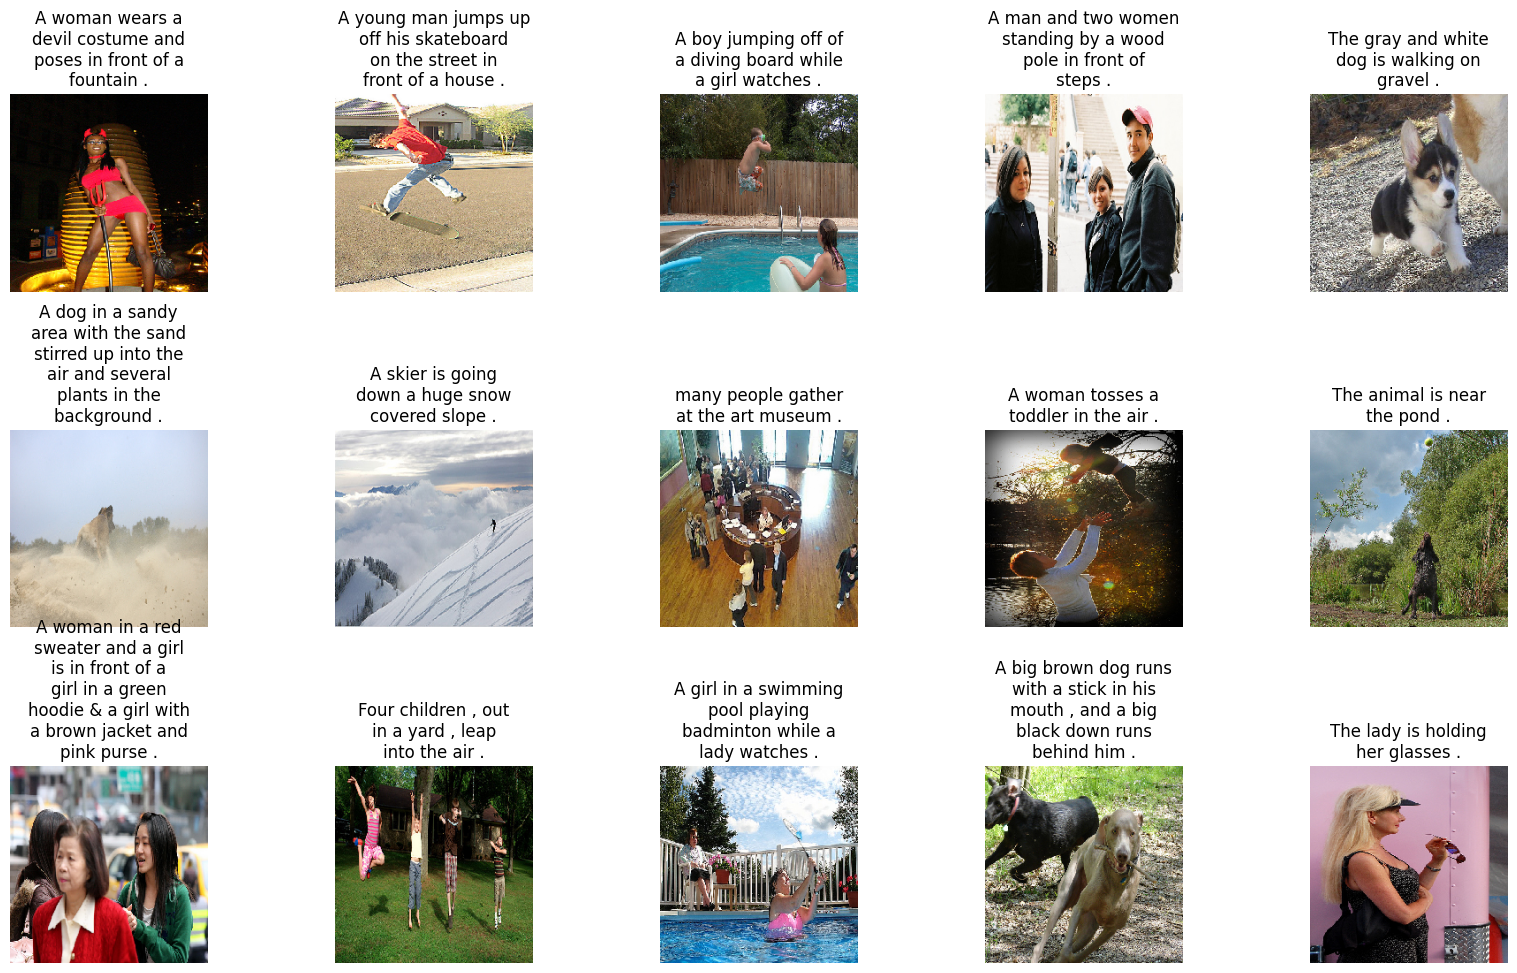

In [8]:
display_images(data.sample(15))

#<font color = "Orange">**Preprocessing of Text**</font>

In [9]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# **Tokenization**

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

#<font color ="SkyBlue">**Image Feature Extraction**</font>

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 8091/8091 [16:12<00:00,  8.32it/s]


In [12]:
import pickle

with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)


In [13]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

#<font color ="Blue">**RNN model**</font>

In [14]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)


sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

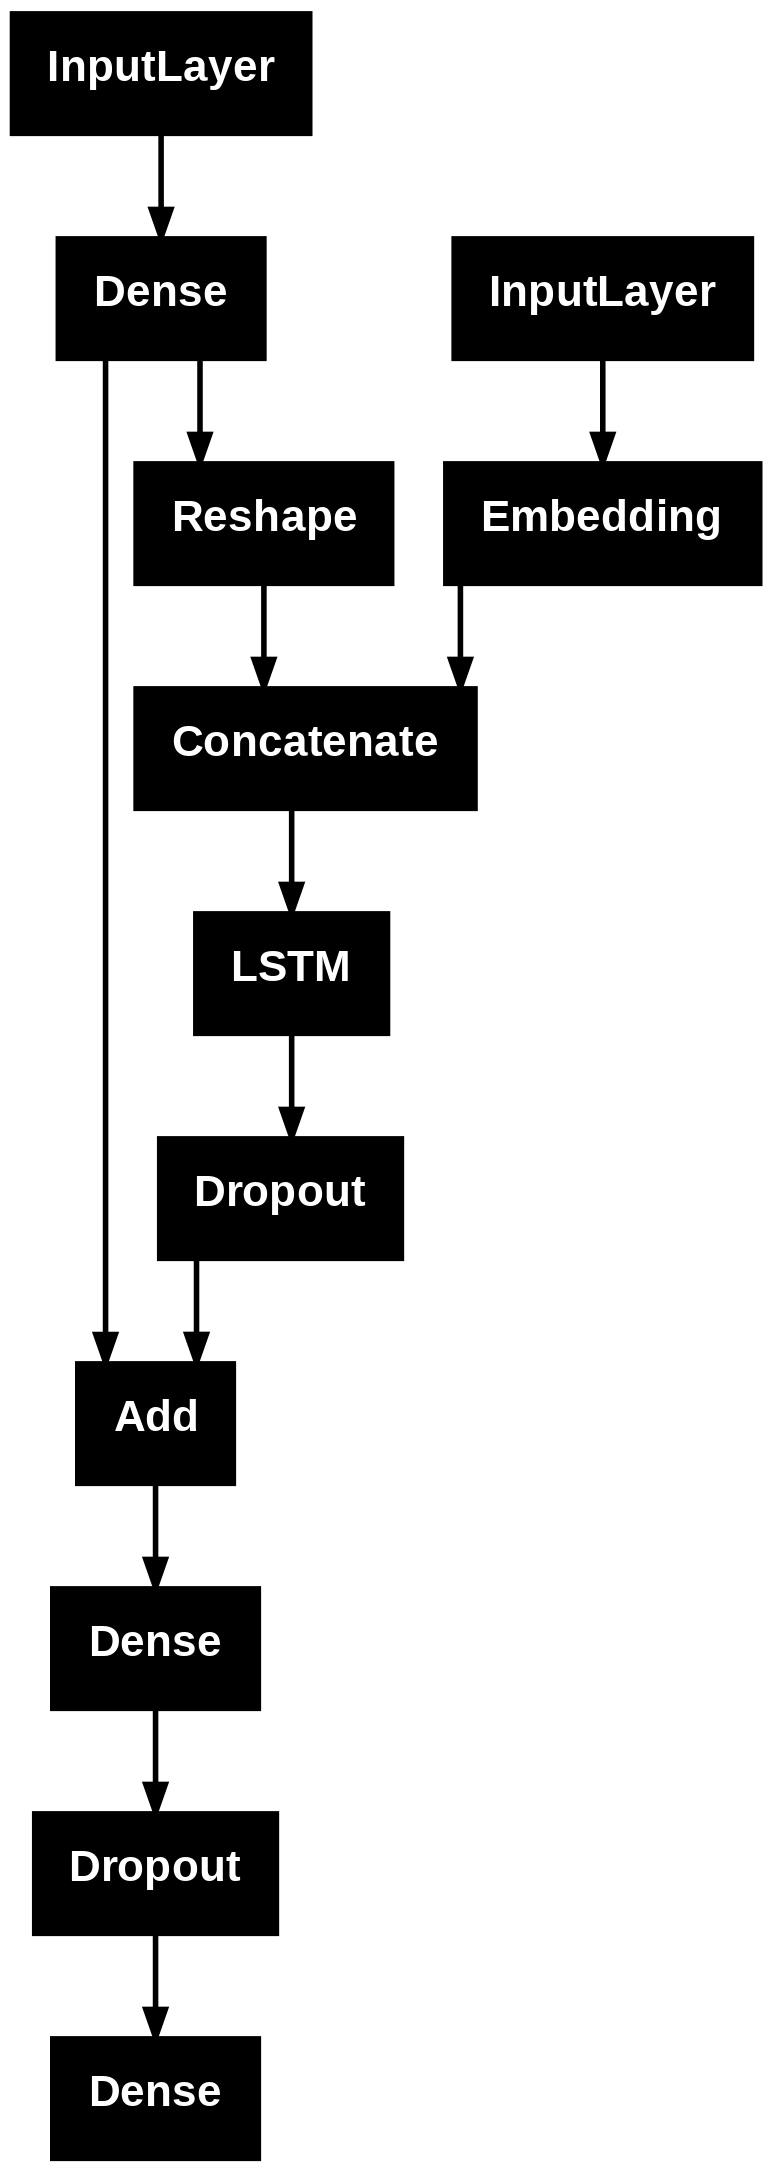

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

#<font color ="Bl">**Full Model**</font>

In [16]:
caption_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [18]:
model_name = "modelfinal.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [19]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 5.6880
Epoch 1: val_loss improved from inf to 4.30486, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 91s 160ms/step - loss: 5.6869 - val_loss: 4.3049 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.3565
Epoch 2: val_loss improved from 4.30486 to 3.98441, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 93s 172ms/step - loss: 4.3564 - val_loss: 3.9844 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.0294
Epoch 3: val_loss improved from 3.98441 to 3.82327, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 94s 175ms/step - loss: 4.0293 - val_loss: 3.8233 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.8543
Epoch 4: val_loss improved from 3.82327 to 3.74542, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 91s 170ms/step - loss: 3.8543 - val_loss: 3.7454 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.7132
Epoch 5: val_loss improved from 3.74542 to 3.69287, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 91s 170ms/step - loss: 3.7132 - val_loss: 3.6929 - learning_rate: 0.0010
Epoch 6/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 3.6112
Epoch 6: val_loss improved from 3.69287 to 3.65925, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 91s 170ms/step - loss: 3.6112 - val_loss: 3.6593 - learning_rate: 0.0010
Epoch 7/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.5274
Epoch 7: val_loss improved from 3.65925 to 3.63940, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - loss: 3.5274 - val_loss: 3.6394 - learning_rate: 0.0010
Epoch 8/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.4533
Epoch 8: val_loss improved from 3.63940 to 3.63446, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - loss: 3.4533 - val_loss: 3.6345 - learning_rate: 0.0010
Epoch 9/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 3.3850
Epoch 9: val_loss improved from 3.63446 to 3.62169, saving model to modelfinal.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 90s 168ms/step - loss: 3.3850 - val_loss: 3.6217 - learning_rate: 0.0010
Epoch 10/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 3.3303
Epoch 10: val_loss did not improve from 3.62169
537/537 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - loss: 3.3304 - val_loss: 3.6401 - learning_rate: 0.0010
Epoch 11/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2870
Epoch 11: val_loss did not improve from 3.62169
537/537 ━━━━━━━━━━━━━━━━━━━━ 98s 183ms/step - loss: 3.2871 - val_loss: 3.6383 - learning_rate: 0.0010
Epoch 12/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2465
Epoch 12: val_loss did not improve from 3.62169

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 90s 168ms/step - loss: 3.2465 - val_loss: 3.6684 - learning_rate: 0.0010
Epoch 13/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1562
Epoch 13: val_loss did not improve from 3.62169
537/537 ━━━━━━━━━━━━━━━━━━━━ 91s 169ms/st

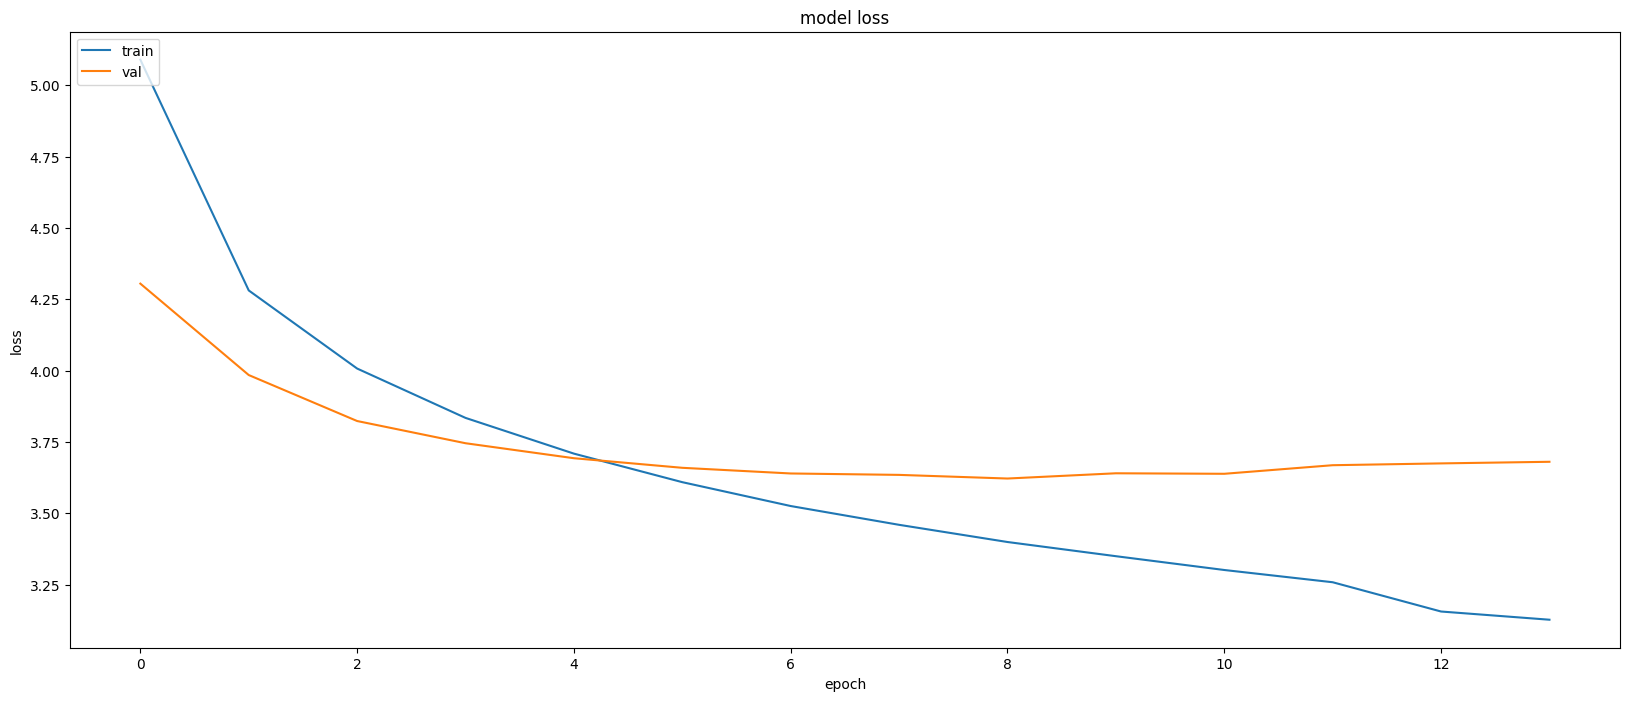

In [20]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [119]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

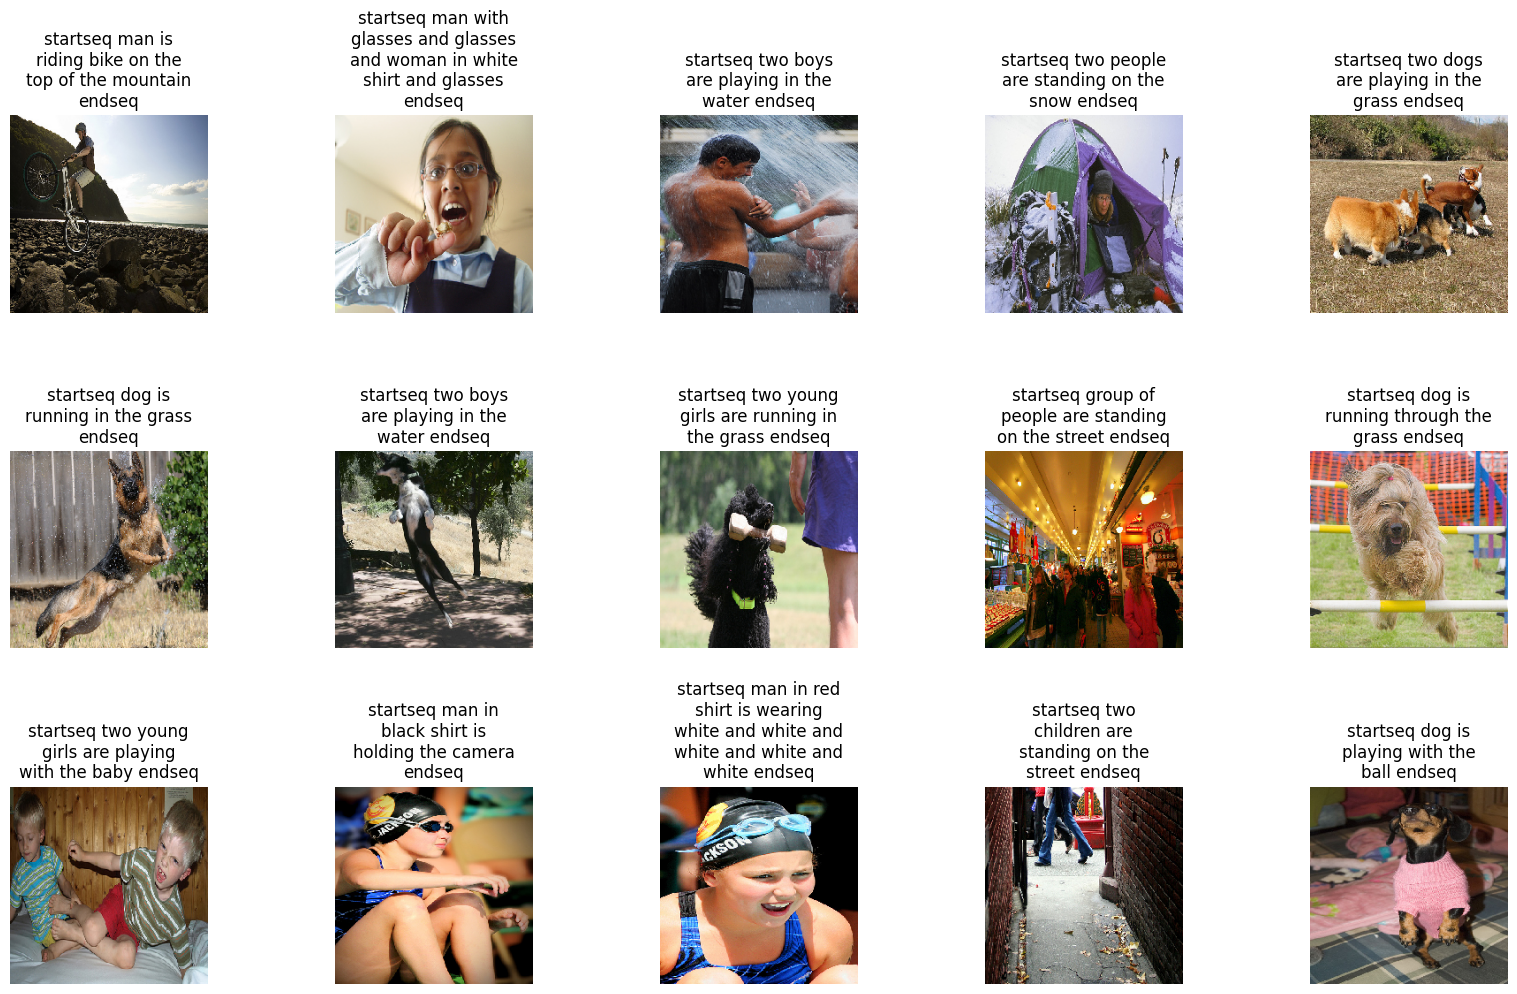

In [120]:
display_images(samples)

In [121]:
def generate_caption_for_single_image_v3(img_path, caption_model, img_tokenizer, max_caption_length, image_features):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))  # Resize the image to match the model input size
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension for prediction

    # Extract the image name from the file path
    img_name = os.path.basename(img_path)

    # Ensure the features for the image are available
    if img_name not in image_features:
        print(f"[ERROR] Feature for image '{img_name}' not found.")
        return None

    # Retrieve the image's features
    img_feature = image_features[img_name]

    # Generate the caption using the predict_caption function
    predicted_caption = predict_caption(caption_model, img_name, img_tokenizer, max_caption_length, image_features)

    # Display the image with its predicted caption
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image for Captioning")
    plt.show()

    return predicted_caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


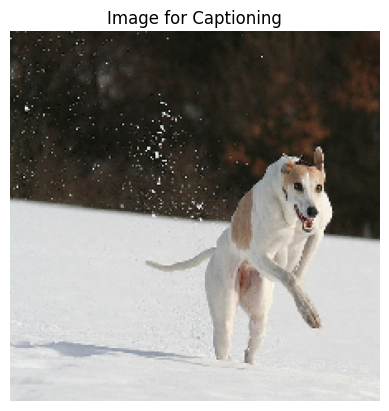

Predicted Caption: dog is running through the snow


In [129]:
# Example usage:
image_path = '/content/images/Images/101654506_8eb26cfb60.jpg'  # Path to the image
#image_path = '/content/images/Images/1030985833_b0902ea560.jpg'

predicted_caption = generate_caption_for_single_image_v3(image_path, caption_model,tokenizer, max_length,features)
#print(f"Predicted Caption: {predicted_caption}")


predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

# Print the cleaned caption
print(f"Predicted Caption: {predicted_caption}")


In [39]:
!pip install gtts

In [130]:
from gtts import gTTS

language='en'
text=predicted_caption
speech=gTTS(text=text,lang=language,slow=False,tld='com.au')
speech.save("captionspeech.mp3")

from IPython.display import Audio

# Play the saved audio
Audio("captionspeech.mp3")

# **Model Evaluation**

In [136]:
!pip install nltk

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [145]:
def load_references(captions_file):
    references = {}
    with open(captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # Skip empty lines

            parts = line.split(',')  # Split by comma
            if len(parts) < 2:
                print(f"Skipping malformed line: {line}")  # Debugging print to identify problematic lines
                continue  # Skip lines that don't contain exactly two parts

            image_filename = parts[0]
            caption = parts[1]
            if image_filename not in references:
                references[image_filename] = []
            references[image_filename].append(caption)
    return references

captions_file = '/content/images/captions.txt'
reference_captions = load_references(captions_file)


In [151]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu


def tokenize_caption(caption):
    return caption.lower().split()

def load_references(captions_file):
    references = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            image_filename = parts[0]
            caption = parts[1]


            if image_filename not in references:
                references[image_filename] = []
            references[image_filename].append(caption)
    return references

# Load the reference captions
captions_file = '/content/images/captions.txt'
reference_captions = load_references(captions_file)


predicted_captions = []
references = []

for index, record in samples.iterrows():
    image_name = record['image']
    predicted_caption = record['caption']

    if image_name in reference_captions:
        ref_captions = reference_captions[image_name]
    else:
        ref_captions = []

    predicted_captions.append(tokenize_caption(predicted_caption))
    references.append([tokenize_caption(ref) for ref in ref_captions])


smooth = SmoothingFunction().method4
bleu_score = corpus_bleu(references, predicted_captions, smoothing_function=smooth)

print(f"BLEU Score: {bleu_score}")


BLEU Score: 0.03677830274048715


In [165]:
!pip install rouge

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [166]:
from nltk.translate.meteor_score import meteor_score

def tokenize_caption(caption):
    return caption.lower().split()

meteor_scores = []
for pred_caption, ref_captions in zip(predicted_captions, references):
    pred_caption_tokens = tokenize_caption(pred_caption)

    best_meteor_score = max([meteor_score([tokenize_caption(ref)], pred_caption_tokens) for ref in ref_captions])
    meteor_scores.append(best_meteor_score)

average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print(f"Average METEOR Score: {average_meteor_score}")


Average METEOR Score: 0.2463375040213318
